In [5]:
from pathlib import Path
DATA_DIR = Path("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data")

# for now the crop thresholds are just very quickly generated, need to look into it better. 
info on the conditions to grow crops: https://gaez.fao.org/pages/ecocrop

In [6]:


# --- Define crop thresholds: (abs_min, opt_min, opt_max, abs_max) for temp and precip ---
crop_params = {
    "arabica": {
        # Temperature in °C: (absolute_min, optimal_min, optimal_max, absolute_max)
        # Below 10°C: unsuitable; Optimal range: 18–22°C; Above 30°C: heat stress likely
        "temp": (10, 18, 22, 30),
        # Annual precipitation in mm: (absolute_min, optimal_min, optimal_max, absolute_max)
        # Below 800 mm: drought stress; 1200–2200 mm: ideal; Above 2800 mm: excessive rain may reduce yield
        "precip": (800, 1200, 2200, 2800)
    },
    "robusta": {
        # Robusta is more heat-tolerant than Arabica; tolerates up to 36°C
        "temp": (15, 22, 26, 36),
        # Higher rainfall needs than Arabica, ideal range is 2000–3000 mm
        "precip": (1000, 2000, 3000, 3500)
    },
    "cacao": {
        # Sensitive to temperature extremes; performs best in 23–27°C
        "temp": (18, 23, 27, 34),
        # Cacao prefers humid conditions; below 1000 mm may cause water stress
        "precip": (1000, 1500, 2500, 3000)
    },
    "banana": {
        # Bananas require warmth; can tolerate higher temps but 25–30°C is optimal
        "temp": (15, 25, 30, 35),
        # Very water-demanding crop; grows best with 1500–2500 mm/year
        "precip": (1000, 1500, 2500, 3000)
    }
}

In [7]:
import xarray as xr
# --- Define file paths ---
DATA_DIR = Path("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data")
temp_path = DATA_DIR / "isimip3a/tas/20crv3-era5_obsclim_tas_global_daily_2011_2020.nc"


In [9]:
import xarray as xr
# --- Define file paths ---
DATA_DIR = Path("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data")
suitability_dir = DATA_DIR / "UNU_data/suitability"
suitability_dir.mkdir(parents=True, exist_ok=True)  # <-- Make sure the directory exists

# --- Load and convert daily data ---
tas = xr.open_dataset(temp_path)['tas'] - 273.15


In [11]:
from climada.hazard import Hazard, Centroids
from climada.util.constants import DEF_CRS
from scipy import sparse


import xarray as xr
import numpy as np

# Growing season filtering
growing_months = [3, 4, 5, 6, 7, 8, 9, 10]
tas_grow = tas.sel(time=tas['time.month'].isin(growing_months))
 
# Yearly aggregates (mean temp, sum precip)
tas_annual = tas_grow.groupby('time.year').mean(dim='time')  # [year, lat, lon]

# Choose your variable
data = tas_annual  # or pr_annual

# Reshape for CLIMADA
years = data.year.values
n_events = len(years)
n_lats = data.lat.size
n_lons = data.lon.size
n_cells = n_lats * n_lons

# Flatten each year to 1D array and stack all into a 2D array
intensity_data = np.vstack([data.sel(year=yr).values.reshape(1, -1) for yr in years])

# Convert to sparse matrix
intensity = sparse.csr_matrix(intensity_data)  # shape: [n_events, n_cells]

# Full coverage (no partial exposure)
fraction = intensity.copy()
fraction.data.fill(1)

# Define centroids using 2D lat/lon grid
# Create lat/lon meshgrid from the data dimensions
lon_vals = data.lon.values
lat_vals = data.lat.values
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
# Flatten to 1D arrays
centroids = Centroids(
    lat=lat_grid.ravel(),
    lon=lon_grid.ravel(),
    crs=DEF_CRS
)

# Create Hazard
haz = Hazard(
    haz_type="TX",  # Temperature hazard, or use "RF" for rainfall
    intensity=intensity,
    fraction=fraction,
    centroids=centroids,
    units="degC" if data is tas_annual else "mm",
    event_id=years,
    event_name=[f"{v}" for v in years],
    date=np.array([np.datetime64(f"{v}-07-01").astype('datetime64[D]').astype(int) for v in years]),
    orig=np.zeros(n_events, dtype=bool),
    frequency=np.ones(n_events) / n_events
)



In [12]:
import numpy as np

intensity_dense = haz.intensity.toarray()  # shape: [n_events, n_cells]

print("Min:", np.min(intensity_dense))
print("Max:", np.max(intensity_dense))
print("Mean:", np.mean(intensity_dense))


Min: -62.390213
Max: 36.015003
Mean: 6.513642


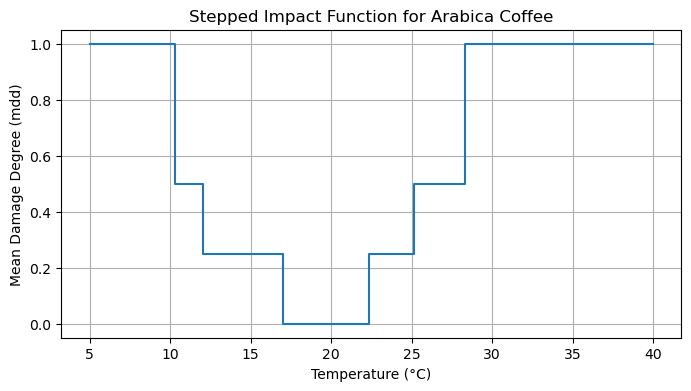

In [16]:
import numpy as np
from climada.entity import ImpactFunc
import matplotlib.pyplot as plt

# Step 1: Define clean temperature bins and corresponding mdd values
# Bins are: (-∞,10), [10,12), [12,17), [17,22], (22,25], (25,28], (28,∞)
bin_edges = [-np.inf, 10, 12, 17, 22, 25, 28, np.inf]
mdd_values = [1.0, 0.5, 0.25, 0.0, 0.25, 0.5, 1.0]  # must match len(bin_edges)-1

# Step 2: Create intensity values
intensity = np.linspace(5, 40, 100)

# Step 3: Assign mdd using digitize
bin_indices = np.digitize(intensity, bin_edges, right=False) - 1
mdd = np.array([mdd_values[i] for i in bin_indices])

# Step 4: Full exposure
paa = np.ones_like(mdd)

# Step 5: Create Impact Function
imp_fun = ImpactFunc(
    id=1,
    name="Arabica TX Discrete",
    haz_type="TX",
    intensity=intensity,
    mdd=mdd,
    paa=paa,
    intensity_unit="°C"
)

imp_fun.check()

# Step 6: Plot as step function
plt.figure(figsize=(8, 4))
plt.step(intensity, mdd, where='post')
plt.xlabel("Temperature (°C)")
plt.ylabel("Mean Damage Degree (mdd)")
plt.title("Stepped Impact Function for Arabica Coffee")
plt.grid(True)
plt.show()

# Store the impact function in impact function set
from climada.entity import ImpactFuncSet
# Create an empty ImpactFuncSet
impf_set = ImpactFuncSet()

# add the 2 impact functions into ImpactFuncSet
imp_fun_set = ImpactFuncSet([imp_fun])

In [23]:
from climada.entity import Exposures
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1. Load your Excel data
df = pd.read_excel("/Users/szelie/data/unu/occurrence_data-1.xlsx", sheet_name='Data')

# 2. Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf_all = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf_coffee = gdf_all[gdf_all.species=="Coffea arabica"]

# Bounding box for Central America
lat_min, lat_max = 5, 20
lon_min, lon_max = -95, -75

# Filter points (or polygon centroids) within that bounding box
central_america = gdf_coffee.cx[lon_min:lon_max, lat_min:lat_max]
exp_occurence = Exposures(data=central_america)

In [24]:
exp_occurence.gdf['value']=1
exp_occurence.gdf['impf_TX']=1

In [25]:
from climada.engine import ImpactCalc

imp = ImpactCalc(exp_occurence, imp_fun_set, haz).impact(
    save_mat=True
)

2025-05-23 09:38:31,111 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


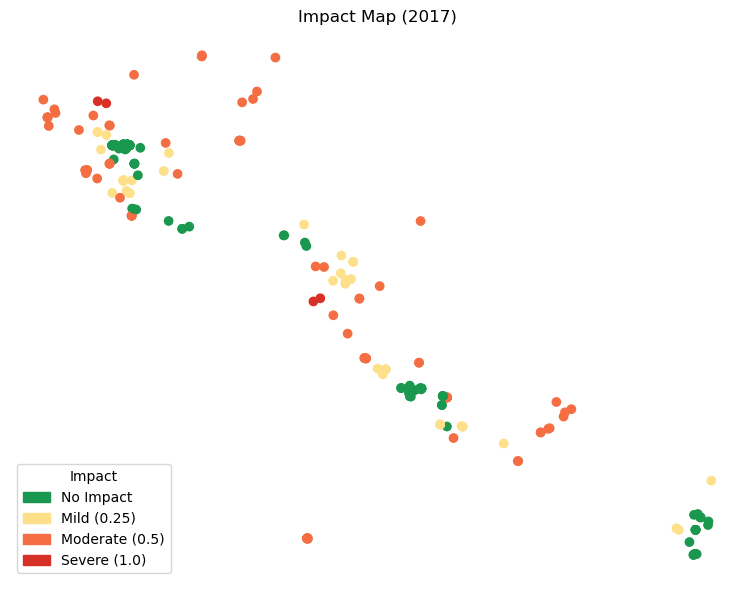

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

# Rebuild the exposure-impact GeoDataFrame for a given year
gdf = imp._build_exp_event(2018).gdf

# Define the unique impact categories and desired colors
impact_levels = [0.0, 0.25, 0.5, 1.0]
colors = ['#1a9850', '#fee08b', '#f46d43', '#d73027']  # green to red

# Create a colormap and normalization based on categories
cmap = mcolors.ListedColormap(colors)
bounds = impact_levels + [1.01]  # upper bound for colorbar
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot with categorical colormap
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(column="value", cmap=cmap, norm=norm, ax=ax)

# Optional: custom legend
from matplotlib.patches import Patch
legend_labels = ['No Impact', 'Mild (0.25)', 'Moderate (0.5)', 'Severe (1.0)']
patches = [Patch(color=c, label=lbl) for c, lbl in zip(colors, legend_labels)]
plt.legend(handles=patches, title="Impact", loc="lower left")

plt.title("Impact Map (2017)")
plt.axis("off")
plt.tight_layout()
plt.show()


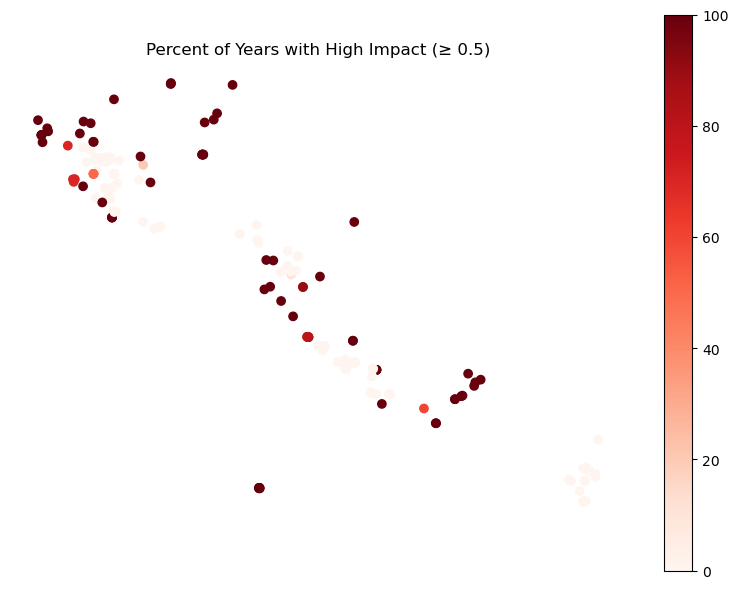

In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Convert sparse matrix to dense NumPy array
imp_array = imp.imp_mat.toarray()  # shape: (n_points, n_events)

# Step 2: Define high impact threshold
threshold = 0.5
high_impact_mask = imp_array >= threshold

# Step 3: Count how many events (years) exceed threshold per grid point
years_high_impact = high_impact_mask.sum(axis=0)
percent_high_impact = 100 * years_high_impact / imp_array.shape[0]

# Step 4: Add to exposure GeoDataFrame
exp_gdf = central_america.copy()
exp_gdf["years_high_impact"] = years_high_impact
exp_gdf["percent_high_impact"] = percent_high_impact

# Step 5: Plot
fig, ax = plt.subplots(figsize=(8, 6))
exp_gdf.plot(column="percent_high_impact", cmap="Reds", legend=True, ax=ax)
plt.title("Percent of Years with High Impact (≥ 0.5)")
plt.axis("off")
plt.tight_layout()
plt.show()


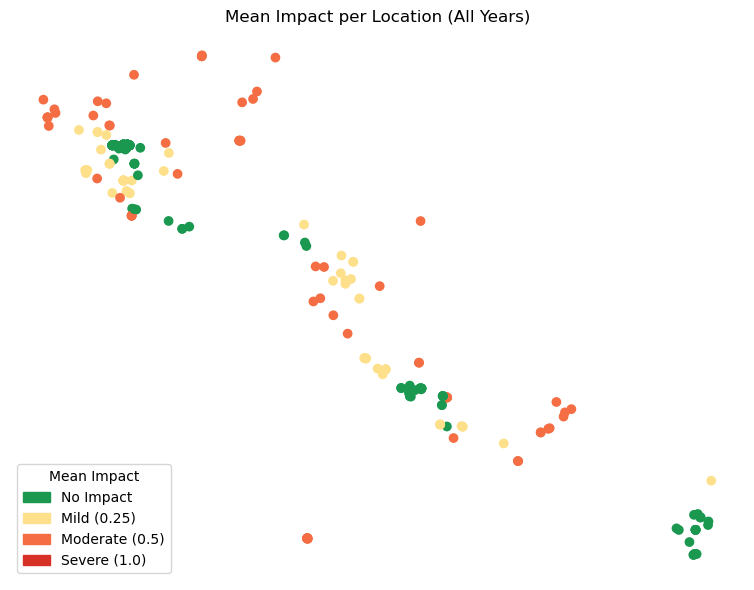

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import geopandas as gpd

# Step 1: Get mean impact per location from imp.imp_mat
mean_impact = imp.imp_mat.toarray().mean(axis=0)  # shape: (n_points,)

# Step 2: Assign to exposure GeoDataFrame
gdf = central_america.copy()
gdf["mean_impact"] = mean_impact

# Step 3: Define custom color bins and categories
impact_levels = [0.0, 0.25, 0.5, 1.0]
colors = ['#1a9850', '#fee08b', '#f46d43', '#d73027']  # from green to red
cmap = mcolors.ListedColormap(colors)
bounds = impact_levels + [1.01]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Step 4: Plot
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(column="mean_impact", cmap=cmap, norm=norm, ax=ax)

# Step 5: Custom legend
legend_labels = ['No Impact', 'Mild (0.25)', 'Moderate (0.5)', 'Severe (1.0)']
patches = [Patch(color=c, label=l) for c, l in zip(colors, legend_labels)]
plt.legend(handles=patches, title="Mean Impact", loc="lower left")

plt.title("Mean Impact per Location (All Years)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [29]:
mean_impact = imp.imp_mat.toarray().mean(axis=0)  # shape: (n_points,)


In [30]:
import pandas as pd
import geopandas as gpd
import numpy as np

# Assume you already have:
# - gdf: all species points (including coffee), already filtered to Central America
# - gdf_coffee: subset of gdf with only Coffea arabica points
# - mean_impact: an array of mean impact values per point in gdf_coffee (same order)

# 1. Assign mean impact to gdf_coffee
gdf_coffee_suitability = central_america.copy()
gdf_coffee_suitability["mean_impact"] = mean_impact

# 2. Categorise suitability
def classify(mean_val):
    if np.isclose(mean_val, 0.0):
        return "Perfect"
    elif np.isclose(mean_val, 1.0):
        return "Unsuitable"
    else:
        return "Intermediate"

gdf_coffee_suitability["suitability_class"] = gdf_coffee_suitability["mean_impact"].apply(classify)

# 3. Merge back into full gdf by geometry
gdf_full = gdf.merge(
    gdf_coffee_suitability[["geometry", "mean_impact", "suitability_class"]],
    on="geometry", how="left"
)

# 4. Filter to non-coffee species only
non_coffee = gdf_full[gdf_full["species"] != "Coffea arabica"]

# 5. Count species co-occurrence by suitability class
species_counts = non_coffee.groupby(["species", "suitability_class"]).size().unstack(fill_value=0)

# 6. Add percentage columns
species_counts["total"] = species_counts.sum(axis=1)
species_counts["pct_perfect"] = 100 * species_counts.get("Perfect", 0) / species_counts["total"]
species_counts["pct_unsuitable"] = 100 * species_counts.get("Unsuitable", 0) / species_counts["total"]

# 7. Sort by relevance
species_counts = species_counts.sort_values("pct_perfect", ascending=False)



In [31]:
import geopandas as gpd
import pandas as pd

# Step 1: Reproject to UTM (for distance in meters)
gdf_coffee = gdf_coffee_suitability.to_crs(epsg=32616)

# Step 2: Split into coffee + other trees
gdf_other = gdf_all[gdf_all["species"] != "Coffea arabica"].copy().to_crs(epsg=32616)

# Step 3: Assign unique coffee ID and preserve original point geometry
gdf_coffee["coffee_id"] = gdf_coffee.index
gdf_coffee["buffer"] = gdf_coffee.geometry.buffer(50)  # replace with buffer

# Step 4: Spatial join — find all trees within 50m of any coffee buffer
joined = gpd.sjoin(
    gdf_other,
    gdf_coffee[["coffee_id", "geometry", "mean_impact", "buffer"]],
    how="inner",
    predicate="within"
)

# Step 5: Calculate distance from each tree to the coffee point
joined["distance_m"] = joined.apply(
    lambda row: row.geometry.distance(row.geometry), axis=1
)

# Step 6: Build long-format dataframe (species near coffee points)
long_df = joined[["coffee_id", "species", "distance_m", "geometry", "mean_impact"]].copy()
long_df["lat"] = long_df["geometry"].apply(lambda g: g.y)
long_df["lon"] = long_df["geometry"].apply(lambda g: g.x)
long_df = long_df[["coffee_id", "lat", "lon", "species", "distance_m", "mean_impact"]].sort_values(["coffee_id", "distance_m"])
long_df.reset_index(drop=True, inplace=True)

# -------------------------------
# ✅ ADD MISSING TREE OBSERVATIONS
# -------------------------------

# Identify coffee IDs already present in long_df
observed_ids = long_df["coffee_id"].unique()

# Identify missing coffee points (with no trees nearby)
no_tree = gdf_coffee[~gdf_coffee["coffee_id"].isin(observed_ids)].copy()
no_tree["species"] = "None"
no_tree["distance_m"] = None
no_tree["lat"] = no_tree["geometry"].apply(lambda g: g.y)
no_tree["lon"] = no_tree["geometry"].apply(lambda g: g.x)

# Keep only matching columns
no_tree_cleaned = no_tree[["coffee_id", "lat", "lon", "species", "distance_m", "mean_impact"]]

# Combine with long_df
long_df = pd.concat([long_df, no_tree_cleaned], ignore_index=True).sort_values(["coffee_id", "distance_m"], na_position='last')
long_df.reset_index(drop=True, inplace=True)


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_16728/2488398408.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  long_df = pd.concat([long_df, no_tree_cleaned], ignore_index=True).sort_values(["coffee_id", "distance_m"], na_position='last')


In [ ]:
gdf_coffee

In [ ]:
# Group by species: calculate mean unsuitability and number of coffee points
species_unsuitability = (
    long_df.groupby("species")["mean_impact"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "avg_unsuitability", "count": "n_coffee_obs"})
)

# Optional: keep only species seen near ≥ 5 coffee points
species_unsuitability = species_unsuitability[species_unsuitability["n_coffee_obs"] >= 5]

# Sort by avg_unsuitability
species_unsuitability = species_unsuitability.sort_values("avg_unsuitability", ascending=False)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Assign impact-based classes
def classify_impact(val):
    if val <= 0.0:
        return "Perfect"
    elif val <= 0.25:
        return "Mild Impact"
    elif val <= 0.5:
        return "Moderate Impact"
    else:
        return "Unsuitable"

long_df["suitability_class"] = long_df["mean_impact"].apply(classify_impact)

# Step 2: Group by species × impact class (raw counts)
species_heat_counts = (
    long_df.groupby(["species", "suitability_class"])
    .size()
    .unstack(fill_value=0)
)

# Step 3: Filter to species with ≥5 total observations
species_heat_counts["total"] = species_heat_counts.sum(axis=1)
species_heat_counts = species_heat_counts[species_heat_counts["total"] >= 5].drop(columns="total")

# Ensure proper column order
categories = ["Perfect", "Mild Impact", "Moderate Impact", "Unsuitable"]
species_heat_counts = species_heat_counts.reindex(columns=categories)

# Step 4: Plot heatmap (raw counts as color)
plt.figure(figsize=(12, 14))
ax = sns.heatmap(
    species_heat_counts,
    cmap="Reds",
    linewidths=0.5,
    annot=True,
    fmt="d",  # integer counts
    cbar_kws={'label': 'Number of Observations'}
)

plt.title("How Often Each Tree Species Appears Near Coffee in Different Impact Conditions")
plt.xlabel("Coffee Suitability Class (Based on Mean Impact)")
plt.ylabel("Tree Species")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the CSV you saved
traits_df = pd.read_csv("/Users/szelie/data/unu/canopy/tree_species_traits_height_range.csv")

# Make sure species names match in both DataFrames
long_df = long_df.merge(traits_df, on="species", how="left")

# Fill missing values (if any) with 0
long_df["shade_score"] = long_df["shade_score"].fillna(0)
long_df["height_max"] = long_df["height_max_m"].fillna(0)
long_df["height_min"] = long_df["height_min_m"].fillna(0)

agg_traits = (
    long_df.groupby("coffee_id")[["shade_score", "height_max", "height_min"]]
    .max()
    .rename(columns={"shade_score": "max_shade_score", "height_max": "max_tree_height", "height_min": "min_tree_height"})
)

gdf_coffee = gdf_coffee.merge(agg_traits, on="coffee_id", how="left")

# Fill missing values for coffee points with no trees nearby
gdf_coffee["max_shade_score"] = gdf_coffee["max_shade_score"].fillna(0)
gdf_coffee["max_tree_height"] = gdf_coffee["max_tree_height"].fillna(0)
gdf_coffee["min_tree_height"] = gdf_coffee["min_tree_height"].fillna(0)


In [ ]:
import geopandas as gpd
import rasterio
from shapely.geometry import box
import pandas as pd

# List of all your canopy raster tiles (expand this with all you downloaded)
tiles = [
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N12W084_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N12W087_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N12W090_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N12W093_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N15W090_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N15W093_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W075_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W096_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W099_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W102_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W105_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W069_Map.tif",
    "/Users/szelie/data/unu/canopy/ETH_GlobalCanopyHeight_10m_2020_N18W072_Map.tif"
]

results = []

# gdf should already be defined with your observations

for tile in tiles:
    with rasterio.open(tile) as src:
        # Reproject to raster CRS
        gdf_rp = gdf_coffee.to_crs(src.crs)

        # Filter points inside raster bounds
        bounds = box(*src.bounds)
        gdf_in_tile = gdf_rp[gdf_rp.geometry.within(bounds)]
        if gdf_in_tile.empty:
            continue

        # Sample raster values
        coords = [(geom.x, geom.y) for geom in gdf_in_tile.geometry]
        values = list(src.sample(coords))
        gdf_in_tile["canopy_height"] = [val[0] for val in values]

        # Optional filter, you already commented this out
        # gdf_in_tile = gdf_in_tile[(gdf_in_tile.canopy_value > 0) & (gdf_in_tile.canopy_value < 255)]

        results.append(gdf_in_tile)

# Combine results if any
if results:
    gdf_combined = gpd.GeoDataFrame(pd.concat(results), crs=gdf_coffee.crs)
    print(gdf_combined.head())
else:
    print("No matching points found in any of the tiles.")


In [ ]:
gdf_coffee =  gdf_coffee.to_crs(src.crs)

In [ ]:
import matplotlib.pyplot as plt

# Drop missing values
gdf_combined = gdf_combined[gdf_combined.canopy_height<250]

df = gdf_combined.dropna(subset=["canopy_height", "max_tree_height", "min_tree_height"])
# Plot error bars for min–max height
plt.errorbar(
    x=df["canopy_height"],
    y=(df["min_tree_height"] + df["max_tree_height"]) / 2,
    yerr=(df["max_tree_height"] - df["min_tree_height"]) / 2,
    fmt='o',
    alpha=0.5,
    ecolor='gray',
    label="Species Height Range"
)

# Add a y=x line for visual reference
plt.plot([0, 35], [0, 35], color='red', linestyle='--', label='1:1 line')

plt.xlabel("Observed Canopy Height (m)")
plt.ylabel("Species Height (midpoint ± range)")
plt.title("Canopy Height vs Expected Tree Height Range")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
gdf_irrigation = gpd.read_file("/Users/szelie/Downloads/gmia_v5_shp/gmia_v5_aai_pct_aei.shp")


In [ ]:
gdf_irrigation.plot("PCT_AAI")

In [ ]:
import geopandas as gpd

# 1. Load irrigation polygons
gdf_irrigation = gpd.read_file("/Users/szelie/Downloads/gmia_v5_shp/gmia_v5_aeigw_pct_aei.shp")

# 2. Reproject to match CRS of your coffee dataset
gdf_irrigation = gdf_irrigation.to_crs(gdf_combined.crs)

# 3. Perform spatial join: assign irrigation % to coffee points
gdf_coffee_irrig = gpd.sjoin(
    gdf_coffee, 
    gdf_irrigation[["geometry", "PCT_AEIGW"]], 
    how="left", 
    predicate="intersects"
)

# 4. Rename for clarity
gdf_coffee_irrig = gdf_coffee_irrig.rename(columns={"PCT_AEIGW": "pct_irrigated"})


In [ ]:
import matplotlib.pyplot as plt

ax = gdf_irrigation.plot(column="PCT_AEIGW", legend=True, figsize=(10, 6), cmap="YlGnBu")
ax.set_xlim(-95, -75)   # Longitude range for Central America
ax.set_ylim(5, 20)       # Latitude range for Central America
ax.set_title("Percentage of Area Equipped for Irrigation (Central America)")
plt.show()


In [ ]:
plt.scatter(gdf_coffee_irrig.pct_irrigated, gdf_coffee_irrig.mean_impact)

In [ ]:
from scipy.stats import pointbiserialr

# Drop rows with NaN in either column
valid = gdf_coffee_irrig[["mean_impact", "pct_irrigated"]].dropna()

# Run the point-biserial correlation
corr, p_val = pointbiserialr(valid["mean_impact"], valid["pct_irrigated"])
print(f"Point-biserial correlation: {corr:.2f}, p-value: {p_val:.4f}")


In [ ]:
gdf_coffee_irrig["irrigated"] = gdf_coffee_irrig["pct_irrigated"] > 50


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-irrigated points (e.g., circles)
gdf_coffee_irrig[gdf_coffee_irrig["irrigated"] == False].plot(
    ax=ax,
    column="mean_impact",  # or "mean_temp", whatever continuous value you use
    cmap="Reds",
    markersize=30,
    legend=True,
    label="No Irrigation",
    marker="o"
)

# Plot irrigated points (e.g., triangles)
gdf_coffee_irrig[gdf_coffee_irrig["irrigated"] == True].plot(
    ax=ax,
    column="mean_impact",
    cmap="Reds",
    markersize=80,
    legend=False,
    label="Irrigated",
    marker="^"
)

# Final touches
plt.title("Coffee Suitability & Groundwater Irrigation")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr
import numpy as np
from climada.hazard import Hazard, Centroids
from climada.util.constants import DEF_CRS
from scipy import sparse
import glob
import os

# Define your paths
path = "/Users/szelie/data/unu/terra_climate/"
tmin_files = sorted(glob.glob(os.path.join(path, "TerraClimate_tmin_*.nc")))
tmax_files = sorted(glob.glob(os.path.join(path, "TerraClimate_tmax_*.nc")))

# Load and merge all years
tmin_all = xr.concat(
    [xr.open_dataset(f)["tmin"].sel(lat=slice(20, 5), lon=slice(-95, -75)) for f in tmin_files],
    dim="time"
)

tmax_all = xr.concat(
    [xr.open_dataset(f)["tmax"].sel(lat=slice(20, 5), lon=slice(-95, -75)) for f in tmax_files],
    dim="time"
)

# Compute mean temperature
tmean = (tmin_all + tmax_all) / 2  # shape: [time, lat, lon]
tmean = tmean.fillna(0)

# Select growing season months
growing_months = [3, 4, 5, 6, 7, 8, 9, 10]
tmean_grow = tmean.sel(time=tmean['time.month'].isin(growing_months))

# Aggregate by year
tmean_annual = tmean_grow.groupby('time.year').mean(dim='time')  # shape: [year, lat, lon]

# Prepare for CLIMADA Hazard object
years = tmean_annual.year.values
n_events = len(years)
n_lats = tmean_annual.lat.size
n_lons = tmean_annual.lon.size
n_cells = n_lats * n_lons

# Stack to 2D array: shape [n_events, n_cells]
intensity_data = np.vstack([tmean_annual.sel(year=yr).values.reshape(1, -1) for yr in years])
intensity = sparse.csr_matrix(intensity_data)

# Fraction (all 1s where data exists)
fraction = intensity.copy()
fraction.data.fill(1)

# Build centroids
lon_vals = tmean_annual.lon.values
lat_vals = tmean_annual.lat.values
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
centroids = Centroids(
    lat=lat_grid.ravel(),
    lon=lon_grid.ravel(),
    crs=DEF_CRS
)

# Create Hazard object
haz = Hazard(
    haz_type="TX",  # e.g. mean Temperature
    intensity=intensity,
    fraction=fraction,
    centroids=centroids,
    units="degC",
    event_id=years,
    event_name=[str(y) for y in years],
    date=np.array([np.datetime64(f"{y}-07-01").astype("datetime64[D]").astype(int) for y in years]),
    orig=np.zeros(n_events, dtype=bool),
    frequency=np.ones(n_events) / n_events
)


In [ ]:
# Compute impact
from climada.engine import ImpactCalc



imp_terra = ImpactCalc(exp_occurence, imp_fun_set, haz).impact(
    save_mat=True
)  # Do not save the results geographically resolved (only aggregate values)


In [ ]:
mean_impact_terra = imp_terra.imp_mat.toarray().mean(axis=0)  # shape: (n_points,)


In [ ]:
mean_impact_terra.shape

In [ ]:
mean_impact = imp.imp_mat.toarray().mean(axis=0)  # shape: (n_points,)


In [ ]:
plt.scatter(mean_impact, mean_impact_terra)
bias = np.mean(mean_impact_terra - mean_impact)
print(f"Mean bias (Terra - ISIMIP): {bias:.2f}")


In [ ]:
rmse = np.sqrt(np.mean((mean_impact_terra - mean_impact) ** 2))
rmse

In [ ]:
# Rebuild the compare DataFrame if needed
df_compare = pd.DataFrame({
    "impact_isimip": mean_impact,
    "impact_terra": mean_impact_terra
})
df_compare["category"] = df_compare["impact_isimip"].apply(classify_impact)

# Define a custom summary function
def summarize(group):
    return pd.Series({
        "count": len(group),
        "mean_isimip": group["impact_isimip"].mean(),
        "mean_terra": group["impact_terra"].mean(),
        "diff_mean": group["impact_terra"].mean() - group["impact_isimip"].mean(),
        "corr": group["impact_isimip"].corr(group["impact_terra"])
    })

# Apply it
summary = df_compare.groupby("category").apply(summarize).sort_index()

# Show result
print(summary)


# Classify ISIMIP and TerraClimate impacts separately
df_compare["category_isimip"] = df_compare["impact_isimip"].apply(classify_impact)
df_compare["category_terra"] = df_compare["impact_terra"].apply(classify_impact)

# Count how many points fall in each category
count_isimip = df_compare["category_isimip"].value_counts().sort_index()
count_terra = df_compare["category_terra"].value_counts().sort_index()

# Combine into one DataFrame for side-by-side comparison
category_counts = pd.DataFrame({
    "ISIMIP": count_isimip,
    "TerraClimate": count_terra
}).fillna(0).astype(int)

print(category_counts)


In [ ]:
from scipy.stats import pointbiserialr

# Drop rows with NaN in either column
gdf_coffee_irrig['mean_impact_terra']=mean_impact_terra
valid = gdf_coffee_irrig[["mean_impact_terra", "pct_irrigated"]].dropna()

# Run the point-biserial correlation
corr, p_val = pointbiserialr(valid["mean_impact_terra"], valid["pct_irrigated"])
print(f"Point-biserial correlation: {corr:.2f}, p-value: {p_val:.4f}")
